In [ ]:
# Basado en el sgte post
# https://gsnchez.com/blog/article/El-metodo-de-monte-carlo
# Algunos métodos de pandas_datareader cambiaron y hubo que modificarlo con respecto al original
# Más info acá
# https://www.datasource.ai/uploads/026d8d16ea1e8f4698e716f66e4aa264.html


import pandas as pd
import datetime as dt
import fix_yahoo_finance as yf
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from matplotlib import style
from google.colab import files

style.use('seaborn')
yf.pdr_override()
symbols = get_nasdaq_symbols()    # cómo se llama cada acción
symbols

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAA,True,Investment Managers Series Trust II AXS First ...,P,,True,100.0,False,NaN,AAA,AAA,False
AAAU,True,Goldman Sachs Physical Gold ETF Shares,Z,,True,100.0,False,NaN,AAAU,AAAU,False
AAC,True,Ares Acquisition Corporation Class A Ordinary ...,N,,False,100.0,False,NaN,AAC,AAC,False
...,...,...,...,...,...,...,...,...,...,...,...
ZXYZ.A,True,Nasdaq Symbology Test Common Stock,Q,Q,False,100.0,True,N,NaN,ZXYZ.A,False
ZXZZT,True,NASDAQ TEST STOCK,Q,G,False,100.0,True,N,NaN,ZXZZT,False
ZYME,True,Zymeworks Inc. Common Shares,N,,False,100.0,False,NaN,ZYME,ZYME,False


In [ ]:
symbols.loc['AMZN']   # Vemos si Amazon está


Nasdaq Traded                                  True
Security Name       Amazon.com, Inc. - Common Stock
Listing Exchange                                  Q
Market Category                                   Q
ETF                                           False
Round Lot Size                                100.0
Test Issue                                    False
Financial Status                                  N
CQS Symbol                                      NaN
NASDAQ Symbol                                  AMZN
NextShares                                    False
Name: AMZN, dtype: object

In [ ]:
symbols.loc['MELI']

Nasdaq Traded                                    True
Security Name       MercadoLibre, Inc. - Common Stock
Listing Exchange                                    Q
Market Category                                     Q
ETF                                             False
Round Lot Size                                  100.0
Test Issue                                      False
Financial Status                                    N
CQS Symbol                                        NaN
NASDAQ Symbol                                    MELI
NextShares                                      False
Name: MELI, dtype: object

In [ ]:
ticker = 'AMZN'
desde= dt.datetime(2018,1,1)
hasta=dt.datetime.today()

# Intentos fallidos de descargar precios de acciones
#data = yf.download(ticker, start=desde, end=hasta)
#data = web.DataReader(ticker, data_source='yahoo', start=desde)['Adj Close']
#f = web.get_data_yahoo(ticker, start=desde)

KeyError: ignored

In [ ]:
failed=[]
passed=[]
acciones=['AMZN', 'MELI']    # podemos agregar más empresas

def collect_data(accio):
  data = pd.DataFrame()
  for t in accio:
    try:
      data[t] = web.DataReader(t,data_source='yahoo',start=desde)['Adj Close']
      passed.append(t)
    except (IOError, KeyError):
      msg= 'NaN'
      failed.append(t)

  print(data)
  return data


data=collect_data(acciones)
print('EXITO:', passed)
print('FALLO:', failed)

Empty DataFrame
Columns: []
Index: []
EXITO: []
FALLO: ['AMZN', 'MELI']


In [ ]:
#  COMO ALTERNATIVA SI FALLA LA DESCARGA DE DATOS, USAMOS UNOS DATOS DE APPLE QUE TENGO
files.upload()

In [ ]:
data1 = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
data = data1['Close']    # nos quedamos con el precio de cierre
data

0        10.68
1        10.71
2        10.63
3        10.90
4        10.86
         ...  
3014    175.01
3015    170.57
3016    170.60
3017    171.08
3018    169.23
Name: Close, Length: 3019, dtype: float64

In [ ]:
log_returns = np.log(1+data.pct_change())
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)
stdev = log_returns.std()

In [ ]:
ticker='AAPL'
days = 100
trials = 10000

In [ ]:
Z = norm.ppf(np.random.rand(days, trials))
retornos_diarios = np.exp(drift + stdev * Z)
camino_de_precios = np.zeros_like(retornos_diarios)
camino_de_precios[0] = data.iloc[-1]

for t in range(1, days):
    camino_de_precios[t] = camino_de_precios[t-1]*retornos_diarios[t]

print(camino_de_precios)
print(camino_de_precios.shape)

[[169.23       169.23       169.23       ... 169.23       169.23
  169.23      ]
 [172.2622556  170.25328412 169.51013264 ... 170.21720168 162.97388683
  165.70876341]
 [170.72223825 171.48614744 168.05075257 ... 172.11610609 159.13704634
  160.97925288]
 ...
 [119.98964481 184.73484632 213.3107537  ... 259.69853763 152.59600635
  141.52946892]
 [126.99642162 184.65308913 224.90782309 ... 253.25563783 150.64174637
  139.8677291 ]
 [128.37567527 188.10046933 218.55086728 ... 258.70810856 150.80903283
  136.91059649]]
(100, 10000)


In [ ]:
df=pd.DataFrame(camino_de_precios)
df_T= df.T
media=df_T.mean().to_frame()  
print(df.shape)
print(media.shape)
media
df


(100, 10000)
(100, 1)


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,...,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000,169.230000
1,172.262256,170.253284,169.510133,171.589441,170.548887,174.533515,167.356596,170.590515,176.462252,170.070092,...,173.621526,175.695696,172.746545,167.414810,175.094462,174.603584,173.543354,170.217202,162.973887,165.708763
2,170.722238,171.486147,168.050753,175.133216,169.867138,174.716715,169.056445,163.982443,180.536463,166.603315,...,174.118371,174.153997,168.500189,168.092737,174.289318,176.457440,172.420562,172.116106,159.137046,160.979253
3,168.048546,168.391532,169.497003,180.030116,172.152867,179.949007,170.070830,169.121438,183.743705,166.156658,...,174.962004,177.030694,168.970845,170.876538,173.702488,177.058101,169.493317,180.979495,160.932548,163.791835
4,158.952671,176.792652,170.639262,183.977723,173.216674,180.360088,174.698152,169.574398,185.967899,162.126897,...,173.606463,172.565338,168.266641,171.574159,170.475475,181.953140,174.907047,185.604497,156.155264,162.271265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,116.298222,179.430676,211.349783,199.510373,202.577513,206.605216,153.793544,234.240785,129.278460,152.067081,...,130.104237,224.894506,124.839067,185.713562,237.140558,150.018323,130.135080,254.693238,149.480998,139.884570
96,115.152578,183.025112,213.946357,200.208689,201.518037,206.333227,151.094693,228.357195,127.963737,155.884526,...,132.601810,231.450616,120.885125,180.083156,243.187683,145.975749,128.462384,250.915911,151.228423,142.745310
97,119.989645,184.734846,213.310754,207.983599,203.332236,202.800681,148.708157,230.993470,124.211011,160.009160,...,132.773233,229.919645,123.181133,182.518527,247.891274,148.496749,127.049582,259.698538,152.596006,141.529469
98,126.996422,184.653089,224.907823,209.823693,207.083115,207.847145,144.208570,232.322267,124.795071,156.910957,...,129.431659,231.546009,120.893980,180.946947,251.980706,145.212879,131.147996,253.255638,150.641746,139.867729


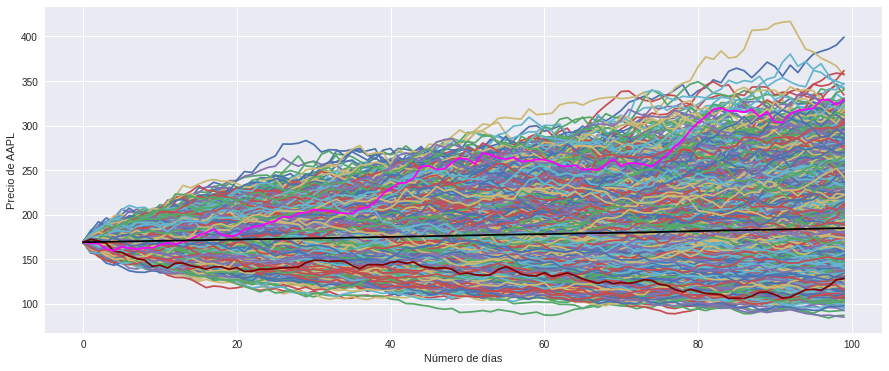

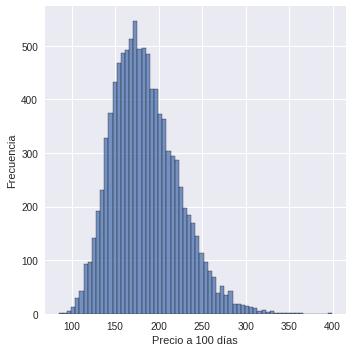

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df)
plt.plot(df[0],'maroon')
plt.plot(df[5000],'magenta')
plt.plot(media, 'black')
plt.xlabel("Número de días")
plt.ylabel("Precio de " + ticker)
sns.displot(df.iloc[-1])
plt.xlabel("Precio a " + str(days) + " días")
plt.ylabel("Frecuencia")
plt.show()



In [ ]:
media


,0
0,169.230000
1,169.347548
2,169.452044
3,169.620574
4,169.766202
...,...
95,184.292662
96,184.464032
97,184.633685
98,184.763249
